# UAC20_Audio Class Device Topology Plotting

In [1]:
%pylab inline  

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'codes')))

path = os.sep.join(['..', '..', '..', '..', '..', '待處理', 'Universal Serial Bus', 'bitbucket', 'github', 'codes'])
sys.path.append(path) 

path = os.sep.join(['..', '..', '..', '..', '..', '待處理', 'ORM', 'bitbucket', 'github', 'codes'])
sys.path.append(path) 
 
import universal_serial_bus
from universal_serial_bus import *
from universal_serial_bus.orm import OrmClassBase #, ModelBuilder,
from usb_audio import Topologen

## USB Codes and Descriptors

In [3]:
from universal_serial_bus.orm.usb20 import *

## UAC Descriptors

In [4]:
from usb_audio.orm.uac20.descriptors import *

In [5]:
# ModelBuilder.gen_all(db_url, True)

## UAC Format Type Descriptors

In [6]:
from usb_audio.orm.uac20.formats.descriptors import *

## Device

In [7]:
idVendor = 0x1b3f
idProduct = 0x2008

dev = universal_serial_bus.USBdevice(vid = idVendor, pid = idProduct)
# print(dev)

## Device descriptor
https://www.beyondlogic.org/usbnutshell/usb5.shtml#DeviceDescriptors  

In [8]:
bmRequestType = usb.util.build_request_type(CONTROL_REQUEST.DIRECTION.IN, 
                                            CONTROL_REQUEST.TYPE.STANDARD, 
                                            CONTROL_REQUEST.RECIPIENT.DEVICE)

In [9]:
descriptor = dev.ctrl_transfer(bmRequestType = bmRequestType, 
                               bRequest = CONTROL_REQUEST.GET_DESCRIPTOR, 
                               wValue = DESCRIPTOR.TYPE.DEVICE << 8, 
                               wIndex = 0, 
                               data_or_wLength = DESCRIPTOR.SIZE.DEVICE)
descriptor

array('B', [18, 1, 16, 1, 0, 0, 0, 8, 63, 27, 8, 32, 0, 1, 1, 2, 0, 1])

## Configuration descriptor
https://www.beyondlogic.org/usbnutshell/usb5.shtml#ConfigurationDescriptors  

In [10]:
descriptor = dev.ctrl_transfer(bmRequestType = bmRequestType, 
                               bRequest = CONTROL_REQUEST.GET_DESCRIPTOR, 
                               wValue = DESCRIPTOR.TYPE.CONFIG << 8, 
                               wIndex = 0, 
                               data_or_wLength = DESCRIPTOR.SIZE.CONFIG)
descriptor

array('B', [9, 2, 253, 0, 4, 1, 0, 128, 50])

### Host 再一次發送 GetDescriptor(Config類) 的請求
完整的長度 = wTotalLength

In [11]:
descriptor = dev.ctrl_transfer(bmRequestType = bmRequestType, 
                         bRequest = CONTROL_REQUEST.GET_DESCRIPTOR, 
                         wValue = DESCRIPTOR.TYPE.CONFIG << 8, 
                         wIndex = 0, 
                         data_or_wLength = descriptor[2])
# descriptor

## 所有的 descriptors

In [12]:
descriptors = list(OrmClassBase.split_descriptor(descriptor))
descriptors

[array('B', [9, 2, 253, 0, 4, 1, 0, 128, 50]),
 array('B', [9, 4, 0, 0, 0, 1, 1, 0, 0]),
 array('B', [10, 36, 1, 0, 1, 100, 0, 2, 1, 2]),
 array('B', [12, 36, 2, 1, 1, 1, 0, 2, 3, 0, 0, 0]),
 array('B', [12, 36, 2, 4, 1, 2, 0, 1, 1, 0, 0, 0]),
 array('B', [9, 36, 3, 3, 1, 3, 0, 6, 0]),
 array('B', [9, 36, 3, 2, 1, 1, 0, 9, 0]),
 array('B', [7, 36, 5, 9, 1, 5, 0]),
 array('B', [10, 36, 6, 6, 8, 1, 1, 2, 2, 0]),
 array('B', [9, 36, 6, 5, 4, 1, 67, 0, 0]),
 array('B', [9, 36, 6, 7, 4, 1, 3, 0, 0]),
 array('B', [13, 36, 4, 8, 2, 1, 7, 2, 3, 0, 0, 0, 0]),
 array('B', [9, 4, 1, 0, 0, 1, 2, 0, 0]),
 array('B', [9, 4, 1, 1, 1, 1, 2, 0, 0]),
 array('B', [7, 36, 1, 1, 1, 1, 0]),
 array('B', [14, 36, 2, 1, 2, 2, 16, 2, 68, 172, 0, 128, 187, 0]),
 array('B', [9, 5, 5, 1, 192, 0, 1, 0, 0]),
 array('B', [7, 37, 1, 1, 0, 0, 0]),
 array('B', [9, 4, 2, 0, 0, 1, 2, 0, 0]),
 array('B', [9, 4, 2, 1, 1, 1, 2, 0, 0]),
 array('B', [7, 36, 1, 2, 1, 1, 0]),
 array('B', [14, 36, 2, 1, 1, 2, 16, 2, 68, 172, 0, 1

## 判斷 descriptors 的種類，並儲存到 db

In [13]:
def is_a(descpt, i, code):
    return OrmClassBase.int_eq_hex(descpt[i], code)

 
def get_descriptor_class(dscrpt, intf_type = None): 
    _class = None
    session = None
    session_usb = session_uac_descriptors = session_uac_format_descriptors  = None
         
    if is_a(dscrpt, 1, '02'):  # 如果是 config
        _class, session = StandardConfigurationDescriptor, session_usb        
     
    if is_a(dscrpt, 1, '05'):  # 如果是 endpoint
        _class, session = StandardEndpointDescriptor, session_usb
        
    if is_a(dscrpt, 1, '04'):  # 如果是 interface
        
        _class, session,  = StandardInterfaceDescriptor, session_usb
        
        if is_a(dscrpt, 5, '01'):  # 如果是 audio
            if is_a(dscrpt, 6, '01'):  # 如果是 AC interface
                intf_type =  "AC" 
            if is_a(dscrpt, 6, '02'):  # 如果是 AC interface
                intf_type =  "AS" 
                        
    if is_a(dscrpt, 1, '24'):  # 如果是 CS_INTERFACE
        session = session_uac_descriptors
        if intf_type == "AC":             
            _classes = {'00': None,
                        '01': ClassSpecificAcInterfaceHeaderDescriptor,
                        '02': InputTerminalDescriptor,
                        '03': OutputTerminalDescriptor,
                        '04': MixerUnitDescriptor,
                        '05': SelectorUnitDescriptor,
                        '06': FeatureUnitDescriptor,
                        '07': 'EFFECT_UNIT',
                        '08': 'PROCESSING_UNIT',
                        '09': 'EXTENSION_UNIT',
                        '0A': ClockSourceDescriptor,
                        '0B': ClockSelectorDescriptor,
                        '0C': ClockMultiplierDescriptor,
                        '0D': SamplingRateConverterUnitDescriptor}
            
            code = OrmClassBase.int_to_hex(dscrpt[2])
            _class = _classes[code]            
            
        if intf_type == "AS":
             
            _classes = {'00': None,
                        '01': ClassSpecificAsInterfaceDescriptor,
                        '02': ExtendedTypeIFormatTypeDescriptor,
                        '03': EncoderDescriptor,
                        '04': 'DECODER'}
            
            code = OrmClassBase.int_to_hex(dscrpt[2])
            _class = _classes[code]            
            if code == '02': session = session_uac_format_descriptors

                        
    if is_a(dscrpt, 1, '25'):  # 如果是 CS_ENDPOINT
        session = session_uac_descriptors
        if intf_type == "AC":             
            _classes = {'00': None,
                        '01': ClassSpecificAcInterfaceHeaderDescriptor,
                        '02': InputTerminalDescriptor,
                        '03': OutputTerminalDescriptor,
                        '04': MixerUnitDescriptor,
                        '05': SelectorUnitDescriptor,
                        '06': FeatureUnitDescriptor,
                        '07': 'EFFECT_UNIT',
                        '08': 'PROCESSING_UNIT',
                        '09': 'EXTENSION_UNIT',
                        '0A': ClockSourceDescriptor,
                        '0B': ClockSelectorDescriptor,
                        '0C': ClockMultiplierDescriptor,
                        '0D': SamplingRateConverterUnitDescriptor}
            
            code = OrmClassBase.int_to_hex(dscrpt[2])
            _class = _classes[code]            
            
        if intf_type == "AS":
             
            _classes = {'00': None,
                        '01': ClassSpecificAsInterfaceDescriptor,
                        '02': ExtendedTypeIFormatTypeDescriptor,
                        '03': EncoderDescriptor,
                        '04': 'DECODER'}
            
            code = OrmClassBase.int_to_hex(dscrpt[2])
            _class = _classes[code]
            if code == '02': session = session_uac_format_descriptors
                
    return _class, session, intf_type 

In [14]:
dbos = []
intf_type = None
i = 0

for descriptor in descriptors:
    _class, session, intf_type = get_descriptor_class(descriptor, intf_type) 
    
    if _class is not None:
        dbo = _class.from_byte_array(descriptor)
        dbos.append(dbo)

In [15]:
import networkx as nx

def draw_graph(graph):
    # create directed networkx graph
    G=nx.DiGraph()

    # add edges
    G.add_edges_from(graph)

    graph_pos = nx.shell_layout(G)

    # draw nodes, edges and labels
    nx.draw_networkx_nodes(G, graph_pos, node_size=1000, node_color='blue', alpha=0.3)
    # we can now added edge thickness and edge color
    nx.draw_networkx_edges(G, graph_pos, width=2, alpha=0.3, edge_color='green')
    nx.draw_networkx_labels(G, graph_pos, font_size=12, font_family='sans-serif')

    # show graph
    plt.show()

In [18]:
graph = Topologen.get_topology_graph_array(dbos)
graph

[("02: OutputTerminalDescriptor'>", "01: InputTerminalDescriptor'>"),
 ("01: InputTerminalDescriptor'>", "04: InputTerminalDescriptor'>"),
 ("06: FeatureUnitDescriptor'>", "03: OutputTerminalDescriptor'>"),
 ("09: SelectorUnitDescriptor'>", "02: OutputTerminalDescriptor'>"),
 ("05: FeatureUnitDescriptor'>", "09: SelectorUnitDescriptor'>"),
 ("08: MixerUnitDescriptor'>", "06: FeatureUnitDescriptor'>"),
 ("04: InputTerminalDescriptor'>", "05: FeatureUnitDescriptor'>"),
 ("04: InputTerminalDescriptor'>", "07: FeatureUnitDescriptor'>"),
 ("01: InputTerminalDescriptor'>", "08: MixerUnitDescriptor'>")]

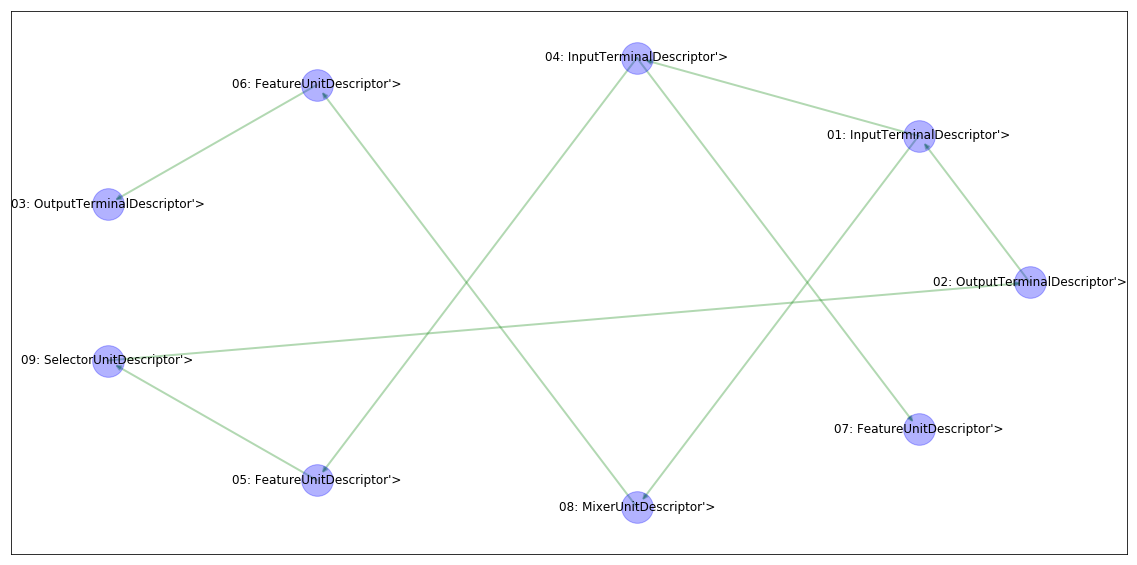

In [17]:
fig = plt.figure(figsize = (20, 10))

draw_graph(graph)